1. Run a PCA based on quantitative environmental variables (see previous exercise), using sites from the
Douro and Tejo basins. Produce a biplot with ‘Catchment_name’ as a grouping variable.
2. Using the same data, run a PCoA and project the sites using the resulting first two axis. Use also the
‘Catchment_name’ as a grouping variable.
3. Run a Linear Discriminant Analysis based on quantitative environmental variables (see previous
exercises), using the Douro and Tejo basins as the pre-determined groups. Produce a biplot with
‘Catchment_name’ as a grouping variable.

/var/folders/nx/dr_pnkkn1yg156jk80s020sc0000gn/T/ipykernel_757/399980100.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


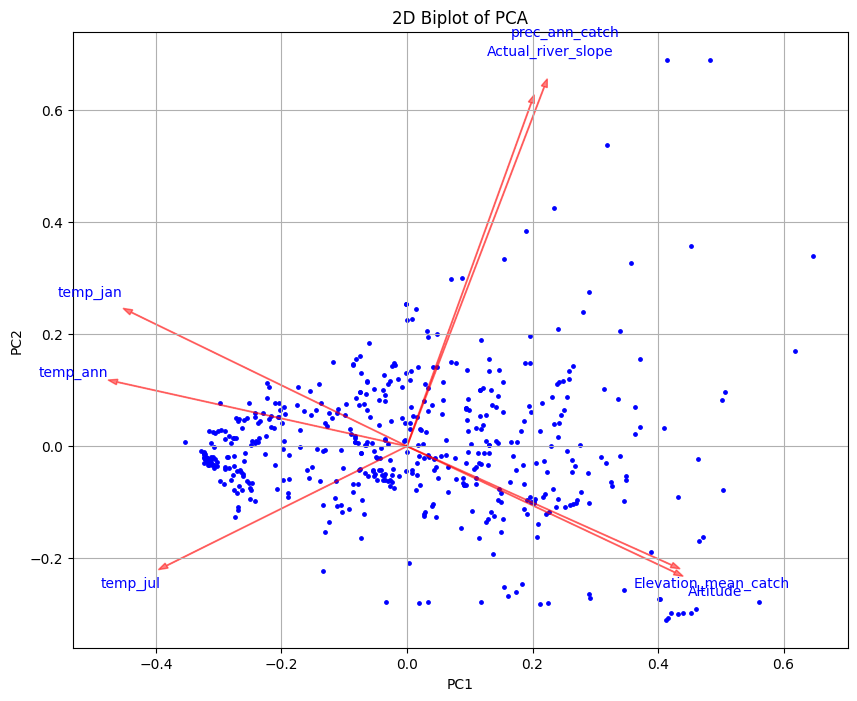

In [18]:
#1 PCA with Filtering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('EFIplus_medit.zip', compression='zip', sep=";")

# Filter for Douro and Tejo basins
df = df[df['Catchment_name'].isin(['Douro', 'Tejo'])]

# Drop rows with missing values
df = df.dropna()

# Select continuous variables
continuous_vars = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 
                   'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']

# Select data for clustering
X = df[continuous_vars]

# Drop rows with missing values
X.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame with scaled data
df_scaled = pd.DataFrame(data=X_scaled, columns=continuous_vars)

# Perform PCA
pca = PCA(n_components=2)  # Only use 2 components for clearer 2D plotting
PC = pca.fit_transform(df_scaled)

# Create a DataFrame with principal components
pca_df = pd.DataFrame(data=PC, columns=['PC1', 'PC2'])
pca_df['Catchment_name'] = df['Catchment_name'].values

# Function to create a 2D biplot
def biplot(score, coef, labels=None):
    xs = score[:, 0]  # PC1 object scores
    ys = score[:, 1]  # PC2 object scores 
    scalex = 1.0 / (xs.max() - xs.min())  # to rescale scores
    scaley = 1.0 / (ys.max() - ys.min())  # to rescale scores
    
    plt.figure(figsize=(10, 8))
    plt.scatter(xs * scalex, ys * scaley, s=6, color='blue')  # scatter plot using rescaled object scores
    
    for i in range(coef.shape[0]):
        plt.arrow(0, 0, coef[i, 0], coef[i, 1], color='red', head_width=0.01, alpha=0.5)  # plot arrows for each variable
        plt.text(coef[i, 0] * 1.15, coef[i, 1] * 1.15, labels[i], color='blue', ha='center', va='center')  # variable labels for each arrow
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title('2D Biplot of PCA')
    plt.grid()
    plt.show()

# Plot the 2D biplot
biplot(PC, np.transpose(pca.components_), continuous_vars)


/var/folders/nx/dr_pnkkn1yg156jk80s020sc0000gn/T/ipykernel_757/2336976496.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


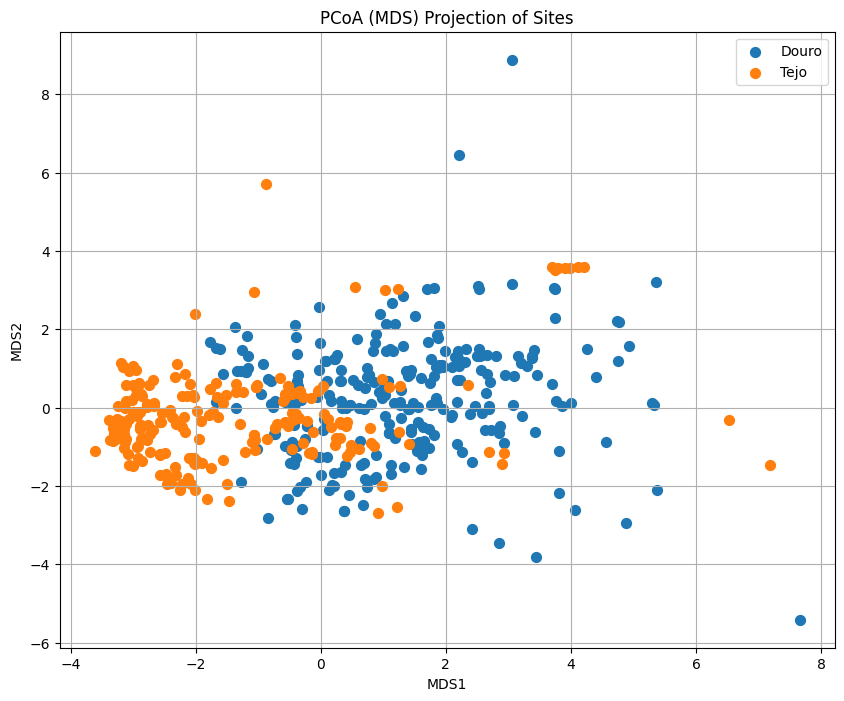

In [19]:
#2 PCoA (MDS) with Filtering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

# Load the dataset
df = pd.read_csv('EFIplus_medit.zip', compression='zip', sep=";")

# Filter for Douro and Tejo basins
df = df[df['Catchment_name'].isin(['Douro', 'Tejo'])]

# Drop rows with missing values
df = df.dropna()

# Select continuous variables and the grouping variable
continuous_vars = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 
                   'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']
group_var = 'Catchment_name'

# Select data for clustering and the grouping variable
X = df[continuous_vars]
group_labels = df[group_var]

# Drop rows with missing values in the selected continuous variables
X.dropna(inplace=True)
group_labels = group_labels[X.index]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCoA (MDS)
mds = MDS(n_components=2, dissimilarity='euclidean', random_state=42)
X_mds = mds.fit_transform(X_scaled)

# Create a DataFrame with MDS results and group labels
mds_df = pd.DataFrame(data=X_mds, columns=['MDS1', 'MDS2'])
mds_df[group_var] = group_labels.values

# Function to create a scatter plot with grouping
def plot_mds(mds_df, group_var):
    unique_groups = mds_df[group_var].unique()
    plt.figure(figsize=(10, 8))
    
    for group in unique_groups:
        group_data = mds_df[mds_df[group_var] == group]
        plt.scatter(group_data['MDS1'], group_data['MDS2'], label=group, s=50)
    
    plt.xlabel('MDS1')
    plt.ylabel('MDS2')
    plt.title('PCoA (MDS) Projection of Sites')
    plt.legend()
    plt.grid()
    plt.show()

# Plot the MDS results
plot_mds(mds_df, group_var)


In [13]:
#3 Run a Linear Discriminant Analysis based on quantitative environmental variables, using the Douro and Tejo basins as the pre-determined groups. 
#Produce a biplot with ‘Catchment_name’ as a grouping variable.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Load the dataset
df = pd.read_csv('EFIplus_medit.zip', compression='zip', sep=";")

# Filter for Douro and Tejo basins
df = df[df['Catchment_name'].isin(['Douro', 'Tejo'])]

# Drop rows with missing values
df = df.dropna()

# Select continuous variables and the grouping variable
continuous_vars = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 
                   'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']
group_var = 'Catchment_name'

continuous_variables = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']
df_continuous = df[continuous_variables]

#standardize the data 

df_continuous_scaled = StandardScaler().fit_transform(df_continuous)
df_scaled = pd.DataFrame(data=df_continuous_scaled, 
                         columns=df_continuous.columns)
df_scaled.head()



,Altitude,Actual_river_slope,Elevation_mean_catch,prec_ann_catch,temp_ann,temp_jan,temp_jul
0,3.002541,-0.635303,3.274284,-0.591536,-2.756492,-2.389199,-2.215321
1,2.481245,-0.500834,2.020549,-1.235061,-2.159600,-2.055191,-1.463074
2,0.994996,-0.619693,0.983347,-1.782173,-0.965816,-1.387173,-0.397390
3,1.934069,-0.462048,1.368290,-1.622130,-1.725497,-1.846435,-0.898889
4,1.867521,-0.425049,1.040247,-1.762416,-1.779760,-1.888186,-1.212325


In [31]:
X = df_scaled
y = df['Catchment_name'] # 2 catchments

#Fit the LDA model (we set to two components)
model = LinearDiscriminantAnalysis(n_components=1)
LDA = model.fit_transform(X, y)

#extract first two discriminate analysis to a df
DLA_scores = pd.DataFrame(data = LDA, 
                            columns = ['LD1'])
DLA_scores.head()

,LD1
0,-1.196125
1,-1.026793
2,-1.369078
3,-1.336983
4,-1.865375


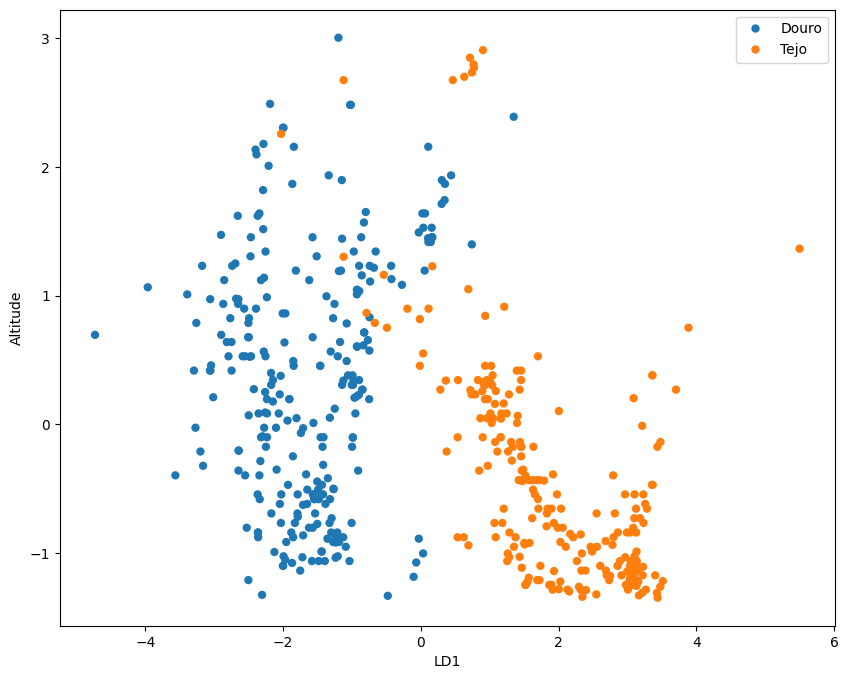

In [34]:
#plot LD1
plt.figure(figsize=(10, 8))

sns.scatterplot(x=LDA_scores['LD1'],
              y=df_scaled['Altitude'],
              hue = df['Catchment_name'].tolist(),
              linewidth=0,
              )
plt.show()

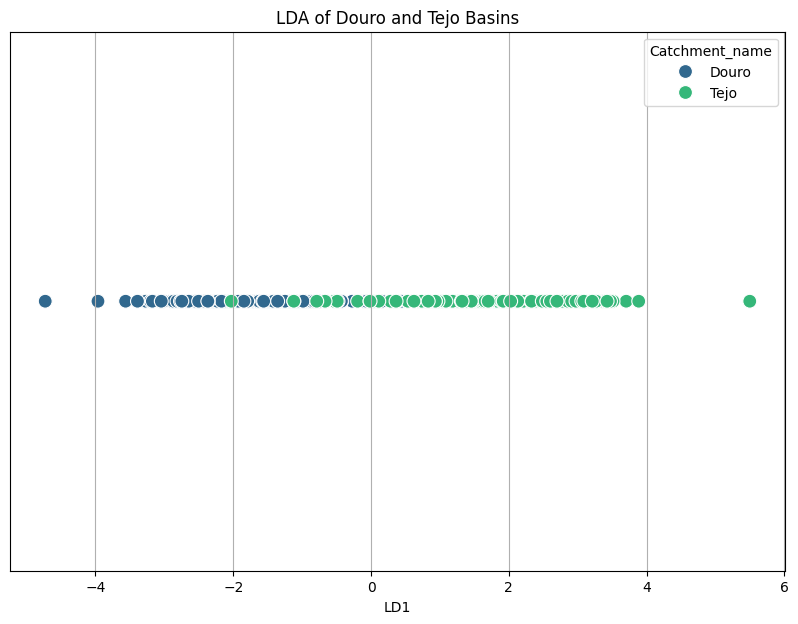

In [35]:
#plot second plane?
X = df_scaled
y = df['Catchment_name']

# Fit the LDA model (we only need one component since we have two classes)
model = LinearDiscriminantAnalysis(n_components=1)
LDA = model.fit_transform(X, y)

# Create a DataFrame for the single linear discriminant
LDA_scores = pd.DataFrame(data=LDA, columns=['LD1'])
LDA_scores['Catchment_name'] = y.values

# Visualize the LDA result
plt.figure(figsize=(10, 7))
sns.scatterplot(x='LD1', y=[0] * len(LDA_scores), hue='Catchment_name', data=LDA_scores, palette='viridis', s=100)
plt.title('LDA of Douro and Tejo Basins')
plt.xlabel('LD1')
plt.yticks([])
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


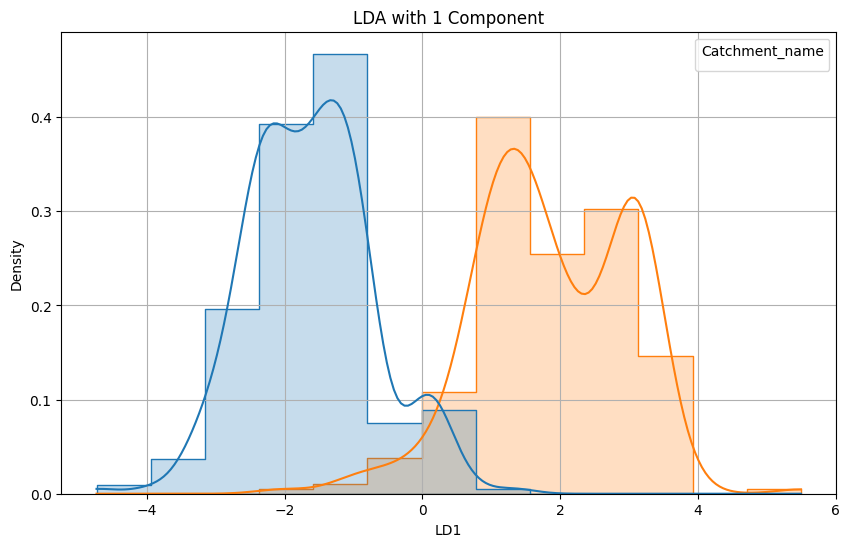

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load the dataset
df = pd.read_csv('EFIplus_medit.zip', compression='zip', sep=";")

# Filter for Douro and Tejo basins
df = df[df['Catchment_name'].isin(['Douro', 'Tejo'])]

# Drop rows with missing values
df = df.dropna()

# Select continuous variables and the grouping variable
continuous_vars = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 
                   'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']
group_var = 'Catchment_name'

# Select data for LDA and the grouping variable
X = df[continuous_vars]
y = df[group_var]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the LDA model with 1 component
model = LinearDiscriminantAnalysis(n_components=1)
LDA = model.fit_transform(X_scaled, y)

# Create a DataFrame with LDA results
lda_df = pd.DataFrame(data=LDA, columns=['LD1'])
lda_df[group_var] = y.values

# Plot the LDA results with 1 component
plt.figure(figsize=(10, 6))

# Use a histogram or density plot to visualize the separation
plot = sns.histplot(data=lda_df, x='LD1', hue=group_var, kde=True, element='step', stat='density', common_norm=False)

plt.xlabel('LD1')
plt.title('LDA with 1 Component')

# Manually specify legend entries
handles, labels = plot.get_legend_handles_labels()
new_labels = {old: old for old in labels}
new_labels.update({handles[0]: 'Douro', handles[1]: 'Tejo'})  # Manually update this if the order is different
plt.legend(handles=handles[1:], labels=new_labels.values(), title=group_var, loc='upper right')  # Adjust legend location as needed

plt.grid()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


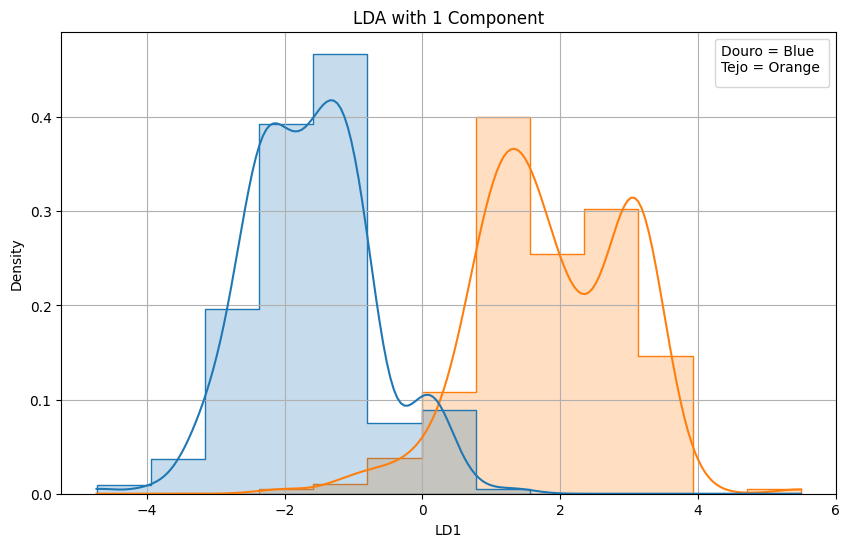

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load the dataset
df = pd.read_csv('EFIplus_medit.zip', compression='zip', sep=";")

# Filter for Douro and Tejo basins
df = df[df['Catchment_name'].isin(['Douro', 'Tejo'])]

# Drop rows with missing values
df = df.dropna()

# Select continuous variables and the grouping variable
continuous_vars = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 
                   'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']
group_var = 'Catchment_name'

# Select data for LDA and the grouping variable
X = df[continuous_vars]
y = df[group_var]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the LDA model with 1 component
model = LinearDiscriminantAnalysis(n_components=1)
LDA = model.fit_transform(X_scaled, y)

# Create a DataFrame with LDA results
lda_df = pd.DataFrame(data=LDA, columns=['LD1'])
lda_df[group_var] = y.values

# Plot the LDA results with 1 component
plt.figure(figsize=(10, 6))

# Use a histogram or density plot to visualize the separation
sns.histplot(data=lda_df, x='LD1', hue=group_var, kde=True, element='step', stat='density', common_norm=False)

plt.xlabel('LD1')
plt.title('LDA with 1 Component')
plt.legend(title="Douro = Blue \nTejo = Orange ", loc='upper right')  # Adjust legend location as needed
plt.grid()
plt.show()
